# Prepare Enviroment
this notebook will show the evaluation results of our algorithms on Fig4.b flash light scene

In [1]:
%load_ext autoreload
! nvidia-smi

Thu Jul 13 13:41:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  N/A |
| 44%   44C    P8    37W / 350W |     23MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 36%   

In [2]:
# use %autoreload command to reload all libraries
%autoreload
import sys
sys.path.append("./YOLOPv1")
sys.path.append("./YOLOv5")
sys.path.append("./datareader")
sys.path.append("..")
import os
import time
import matplotlib.pyplot as plt
import numpy as np

import argparse, time, os, random
from math import log10
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
import cv2

/home/lyh/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# prepare model

In [3]:
%autoreload
name = 'rushwhenDrive1'
from tianmoucv.alg import cal_optical_flow,flow_to_image
from tianmoucv.nn import compute_iou

from opticalFilter import opticalDetector_Maxone
from YOLOPv1detector import YOLOPv1detector
from YOLOv5detector import YOLOv5detector_SD 
from KalmanTrackor import * 
from opticalFilter import opticalDetector_Maxone

detectorPv1 = YOLOPv1detector(path = './YOLOPv1/weights/yolopv1_170e.pth')
detectorPv1._get_normalizer(mean=[0.39556265,0.42169937,0.65865874],
                            std=[0.18127572356817837,0.261213080783536,0.6503947447629356])

detectorv5 =YOLOv5detector_SD(path = './YOLOv5/weights/YOLOv5_400e_320x160_fp32trained.pt')

import TianmouCV, via Y. Lin, T. Wang


YOLOv5detector: iou_thres=0.5, conf_thres=0.25, imgsz=320, task=val, device=cuda:0, half=False, data=./YOLOv5/data/bdd100k.yaml, cfg=./YOLOv5/models/yolov5_tianmouc.yaml 


finish build model


Fusing layers... 


bulid model finished


YOLOv5_tianmouc summary: 213 layers, 1772119 parameters, 0 gradients


# prepare data

In [4]:
import numpy as np
import os
import struct
import cv2,sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math
from tianmoucv.isp import lyncam_raw_comp,demosaicing_npy
sys.path.append("../datareader")

# an easy data read tool
def read_data(dataset,key,idx):
    sample = dict([])

    itter = 26
    rgb_processed,_,_,_,old_conetimeStamp,conefilename = dataset.readFile(key,idx,0,viz=False,ifSync =True)
    rgb_processed = lyncam_raw_comp(rgb_processed)
    rgb = demosaicing_npy(rgb_processed, 'bggr', 1, 10)/1024
    sample['F0'] = torch.FloatTensor(rgb).permute(2,0,1)
    rgb_processed,_,_,_,new_conetimeStamp,_ = dataset.readFile(key,idx+1,0,viz=False,ifSync =True)
    rgb_processed = lyncam_raw_comp(rgb_processed)
    rgb = demosaicing_npy(rgb_processed, 'bggr', 1, 10)/1024
    sample['F1'] = torch.FloatTensor(rgb).permute(2,0,1)
    tsd = torch.zeros([3,itter,160,320])
    gap = 0
    mingap = 0
    maxgap = 0
    bias = -2
    for i in range(-3,3):
        bias = i
        _,tdt,sdt,rodtimeStamp,_,_ = dataset.readFile(key,start,idx*(25)+0+bias,viz=False,ifSync =True)
        mingap = abs(old_conetimeStamp-rodtimeStamp)  
        _,tdt,sdt,rodtimeStamp,_,_ = dataset.readFile(key,start,idx*(25)+itter-1+bias,viz=False,ifSync =True)
        maxgap = abs(new_conetimeStamp-rodtimeStamp)
        if maxgap < 130 or mingap<130:
            #print('bias:',bias)
            break

    for i in range(itter):
        _,tdt,sdt,rodtimeStamp,_,_ = dataset.readFile(key,start,idx*(25)+i+bias,viz=False,ifSync =True)
        if i == 0:
            mingap = abs(old_conetimeStamp-rodtimeStamp) 
        if i == itter-1:
            maxgap = abs(new_conetimeStamp-rodtimeStamp) 
        sdt = sdt.permute(2,0,1)
        td_inter = F.interpolate(tdt.unsqueeze(0).unsqueeze(0), 
                                               (tdt.shape[0],tdt.shape[1]*2), mode='bilinear')
        sd_inter = F.interpolate(sdt.unsqueeze(0), (sdt.shape[1],sdt.shape[2]*2), mode='bilinear')
        td_inter = td_inter.squeeze(0).squeeze(0)
        sd_inter = sd_inter.squeeze(0)
        tsd[0,i,:,:] = td_inter
        tsd[1:3,i,:,:] = sd_inter

    sample['tsdiff'] = tsd
    if maxgap > 30 or mingap>30:
        print('missing sample:',maxgap,mingap)
        return -1
    #print(cone,'/',dataset.dataNum(key),'--',key,' sync time gap:',maxgap,'/',mingap,'us')
    #filename = savePath + '/' + key + '_'+ str(cone) + '.npy'
    #np.save(filename, sample)
    return sample,conefilename

# Evaluate the algorithm

- the ground truth is the sparse reconstructed rgb frames
- COP:YOLOP **blue boxes are COP results**
- AOP:YOLOv5+optical flow filter **red boxes are AOP results**

['flicker2_90cop_90_2995649.npy', 'flicker2_90cop_96_3015253.npy', 'flicker2_90cop_92_3002184.npy', 'flicker2_90cop_88_2989115.npy', 'flicker2_90cop_89_2992382.npy', 'flicker2_90cop_97_3018520.npy', 'flicker2_90cop_93_3005451.npy', 'flicker2_90cop_95_3011986.npy', 'flicker2_90cop_91_2998917.npy', 'flicker2_90cop_94_3008719.npy']


/home/lyh/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


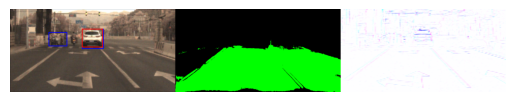

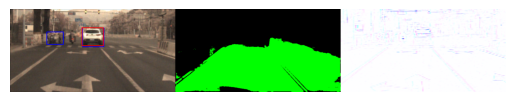

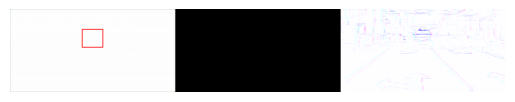

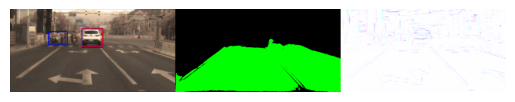

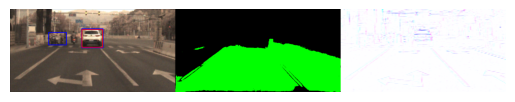

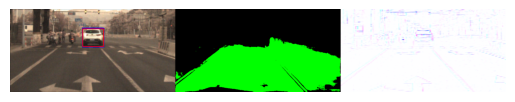

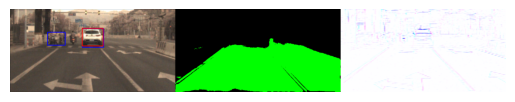

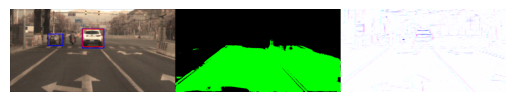

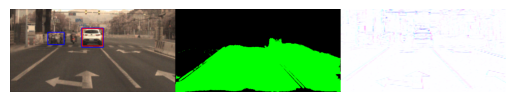

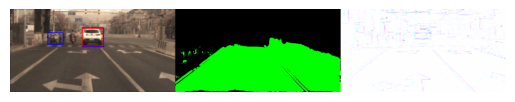

In [5]:
%autoreload
%matplotlib inline
import matplotlib.pyplot as plt
from models.common import DetectMultiBackend
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, check_dataset, check_img_size, check_requirements, check_yaml,
                           coco80_to_coco91_class, colorstr, emojis, increment_path, print_args,
                           scale_coords, xywh2xyxy, xyxy2xywh)
from utils.metrics import ConfusionMatrix, ap_per_class, box_iou
from utils.plots import output_to_target, plot_images, plot_val_study
from utils.torch_utils import select_device, time_sync
from libs.core.general import non_max_suppression


# test if it is a correct detction under a given mIOU threshold
def process_batch(detections, labels, iouv):
    """
    Return correct predictions matrix. Both sets of boxes are in (x1, y1, x2, y2) format.
    Arguments:
        detections (Array[N, 6]), x1, y1, x2, y2, conf, class
        labels (Array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (Array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)

evaluate = True
single_cls = True # if only single class
addOpticalFlow = False # if add optical flow filter on AOP
# OF need raw file
rawdataset = None
if addOpticalFlow:
    import rawDataReadTool as rdrt
    rawdataset = rdrt.TianmoucDataRead(8,dataset_top = "../../data/tianmouc_raw_data")

count = 0

'''
key ='rushwhenDrive1'    #Fig4 OOD
key ='anomaly9'          #no used in paper
key ='flicker290cop'    #Fig4 flash
key ='jiantoucunlong'   #Fig4 Comlex
key ='tunnelbyq91332ae' #Fig4 Tunnel HDR
'''

key ='flicker290cop'  
evaluationPath = '../../data/tianmouc_evaluation_data/'+key

accumTime = 1
dataList = os.listdir(evaluationPath + '/raw') 
optifilt = opticalDetector_Maxone(noiseThresh = 1.6*accumTime,distanceThresh=0.2)

SDstate = []
RGBstate = []
Hybridstate = []
single_cls = True
count = 0
print(dataList)

imlist = []

for filename in dataList:
    labelsList = []
    labelfile = None
    sample = None

    filename = filename.split('.')[0]
    RawName = evaluationPath + '/raw/' + filename + '.npy'
    labelName = evaluationPath + '/label/' + filename + '.txt'
    sample = np.load(RawName,allow_pickle=True).item()
    labelfile = open(labelName,'r')  

    file_data = labelfile.readlines() 
    for row in file_data:
        tmp_list = row.split(' ') 
        labelsList.append([float(e) for e in tmp_list]) 
    
    if evaluate:
        count +=1 
        
        #cop0,cop1,aop0~26
        F0,F1,tsdiff = sample['F0'],sample['F1'],sample['tsdiff']
        
        
        F0_batch = torch.zeros([1,3,320,640])
        F0_batch[0,...] = F0
        sd_imlist = []
        sd_detect = []
        SDtargets = torch.zeros([len(labelsList),6]).to(detectorv5.model.device)
        RGBtargets = torch.zeros([len(labelsList),6]).to(detectorPv1.device)
        HybTargets = torch.zeros([len(labelsList),6]).to(detectorPv1.device)
        for i in range(len(labelsList)):
            cls,x,y,w,h = labelsList[i]
            if single_cls:
                cls = 0
            SDtargets[i,1:]=torch.FloatTensor([cls,x*320,y*160,w*320,h*160])
            RGBtargets[i,1:]=torch.FloatTensor([cls,x*640,y*320,w*640,h*320])
            HybTargets[i,1:]=torch.FloatTensor([cls,x*640,y*320,w*640,h*320])
        
        #===========Only single COP===========
        iouv = torch.linspace(0.5, 0.95, 10, device=detectorPv1.device)  # iou vector for mAP@0.5:0.95
        niou = iouv.numel()
        F0_batch = F0_batch.to(detectorPv1.device)
        img_det,img_seg_safe,img_seg_line,RGBpred,RGBout = detectorPv1(F0_batch)
        si = 0
        if single_cls:
            RGBpred[:, 5] = 0
        labels = RGBtargets[RGBtargets[:, 0] == si, 1:]
        nl, npr = RGBtargets.shape[0], RGBpred.shape[0]  # number of labels, predictions
        correct = torch.zeros(npr, niou, dtype=torch.bool, device=detectorPv1.device)  # init
        if npr == 0:
            if nl:
                RGBstate.append((correct, *torch.zeros((2, 0), device=detectorPv1.device), labels[:, 0]))
        # Predictions
        predn = RGBpred.clone()
        # Evaluate
        if nl:
            tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
            labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
            correct = process_batch(predn, labelsn, iouv)
        RGBstate.append((correct, RGBpred[:, 4], RGBpred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)
        
        #===========Only single AOP===========
        for t in range(1,26):
            iouv = torch.linspace(0.5, 0.95, 10, device=detectorv5.device)  # iou vector for mAP@0.5:0.95
            niou = iouv.numel()
            SD_batch = tsdiff[1:,t,...].unsqueeze(0)
            SD_batch = SD_batch.to(detectorv5.model.device) 
            SD_show = torch.cat([tsdiff[1:,t,...],torch.zeros(1,160,320)],dim=0) / 128.0
            SD_show = np.ascontiguousarray(SD_show.permute(1,2,0).numpy())
            SDpreds,SDout = detectorv5(SD_batch,SD_show)
            #=========== add OF filter, if have raw data===========
            if addOpticalFlow:
                sd = 0
                td = 0
                for i in range(accumTime):
                    rgb,tdt,sdt,rodtimeStamp,conetimeStamp ,_= rawdataset.readFile(key,cone_id ,cone_id *(25)+t+i
                                                                                ,viz=False,ifSync =False)
                    Ix = np.zeros(tdt.shape)
                    Iy = np.zeros(tdt.shape)
                    sdul = sdt[0::2,...,0]
                    sdll = sdt[1::2,...,0]
                    sdur = sdt[0::2,...,1]
                    sdlr = sdt[1::2,...,1]
                    Ix[::2,...] = Ix[1::2,...]= (-(sdul + sdll)/1.414 + (sdur + sdlr)/1.414)/2
                    Iy[1::2,...]= Iy[::2,...] = ((sdur - sdlr)/1.414 + (sdul - sdll)/1.414)/2
                    sd += torch.FloatTensor(np.stack([Ix,Iy],axis=2))
                    td += -tdt
                sd = sd.permute(2,0,1)
                td = td.unsqueeze(0)
                box,area,flowup = optifilt(sd,td)
                if not box is None:
                    x1,y1,x2,y2 = box
                    opticalDetection[0,0] = x1/2.0
                    opticalDetection[0,1] = y1/2.0
                    opticalDetection[0,2] = x2/2.0
                    opticalDetection[0,3] = y2/2.0
                    opticalDetection[0,4] = 1
                    SDpred = torch.cat([SDpred,opticalDetection],dim=0)
                    cv2.rectangle(img_det, (int(x1),int(y1)), (int(x2),int(y2)), (139, 0, 0), 2)
            #print('SD output shape:',SDout.shape)
            SDpred = SDpreds[0]
            
            canvas = np.zeros([img_det.shape[0],img_det.shape[1]*3,3])
            canvas[:,:img_det.shape[1],:] = img_det
            canvas[:,img_det.shape[1]:2*img_det.shape[1],:] = img_seg_safe + img_seg_line
            SD_show = 1 - SD_show
            canvas[:,2*img_det.shape[1]:,:] = cv2.resize(SD_show,(640,320))
            for i in range(SDpred.shape[0]):
                x1 = int(SDpred[0,0]*2)
                y1 = int(SDpred[0,1]*2)
                x2 = int(SDpred[0,2]*2)
                y2 = int(SDpred[0,3]*2)
                cv2.rectangle(canvas, (int(x1),int(y1)), (int(x2),int(y2)), (139, 0, 0), 2)
            canvas[canvas>=1] = 1
            imlist.append(canvas)
            if t==12:
                plt.xticks([])
                plt.yticks([])
                plt.axis('off')
                plt.imshow(canvas)
                plt.show()
            
            si = 0
            if single_cls:
                SDpred[:, 5] = 0
            labels = SDtargets[SDtargets[:, 0] == si, 1:]
            nl, npr = SDtargets.shape[0], SDpred.shape[0]  # number of labels, predictions
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=detectorv5.device)  # init
            if npr == 0:
                if nl:
                    SDstate.append((correct, *torch.zeros((2, 0), device=detectorv5.device), labels[:, 0]))
                continue
            # Predictions
            predn = SDpred.clone()
            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            SDstate.append((correct, SDpred[:, 4], SDpred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)

            #=========== complement algorithm results with NMS ===========
            SDoutClass = torch.zeros([1,SDout.shape[1],6]).to(detectorPv1.device)
            SDoutClass[:,:,:4] =  SDout[:,:,:4]*2
            SDoutClass[:,:,4] = SDout[:,:,4]
            _,SDoutClass[:,:,5] = torch.max(SDout[:,:,5:],dim=-1)
            
            hybout = torch.cat([SDoutClass,RGBout],dim=1)
            hybridPred = non_max_suppression(hybout, 0.5, 0.5)[0]

            iouv = torch.linspace(0.5, 0.95, 10, device=detectorPv1.device)  # iou vector for mAP@0.5:0.95
            niou = iouv.numel()
            si = 0
            if single_cls:
                hybridPred[:, 5] = 0
            labels = HybTargets[HybTargets[:, 0] == si, 1:]
            nl, npr = HybTargets.shape[0], hybridPred.shape[0]  # number of labels, predictions
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=detectorPv1.device)  # init
            if npr == 0:
                if nl:
                    Hybridstate.append((correct, *torch.zeros((2, 0), device=detectorPv1.device), labels[:, 0]))
                continue
            # Predictions
            predn = hybridPred.clone()
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            Hybridstate.append((correct, hybridPred[:, 4], hybridPred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)

In [6]:
print('                MP              MR                  MAP50             map5_95' )

stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*SDstate)]  # to numpy
if len(stats) and stats[0].any():
    tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir=None, names={'name':'yolov5s'})
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    mp, mr, map50, map5_95 = p.mean(), r.mean(), ap50.mean(), ap.mean()
    print('AOP:',mp, mr, map50,map5_95)
    
stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*RGBstate)]  # to numpy
if len(stats) and stats[0].any():
    tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir=None, names={'name':'yolov5s'})
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    mp, mr, map50, map5_95 = p.mean(), r.mean(), ap50.mean(), ap.mean()
    print('COP:',mp, mr, map50,map5_95)
    
stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*Hybridstate)]  # to numpy
if len(stats) and stats[0].any():
    tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir=None, names={'name':'yolov5s'})
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    mp, mr, map50, map5_95 = p.mean(), r.mean(), ap50.mean(), ap.mean()
    print('CVP:',mp, mr, map50,map5_95)
    
    
def images_to_video(frame_list,name,Val_size=(512,256)):
    fps = 5    
    size = (Val_size[0]*3, Val_size[1]) 
    out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frame_list:
        frame = frame[:,:,[2,1,0]] * 255
        w = Val_size[0]
        h = Val_size[1]
        frame = frame.astype(np.uint8)
        out.write(frame)
    out.release()

images_to_video(imlist,'../../results/demo_flash.avi',Val_size=(640,320))

                MP              MR                  MAP50             map5_95
AOP: 0.4575497792359639 0.27485714285714286 0.37247344117157666 0.21209432418512172
COP: 0.7837040853188224 0.14285714285714285 0.41693065268065277 0.3045178394407306
CVP: 0.7110332086588574 0.2139988525530694 0.4180692412742627 0.24137238338700923


/data/lyh/submit/code/demo/./YOLOv5/utils/metrics.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
